In [9]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

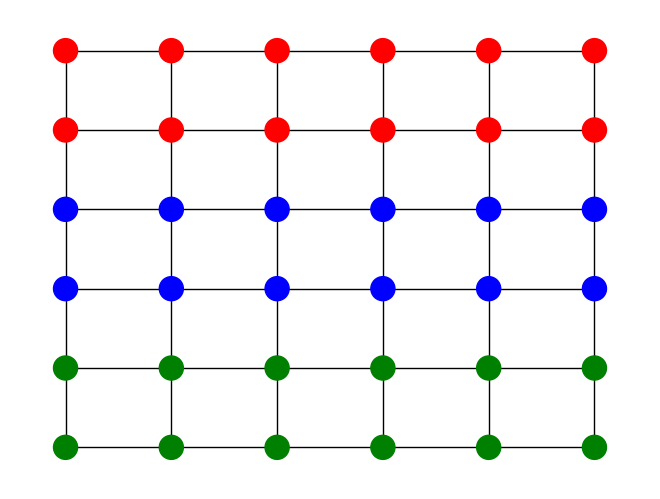

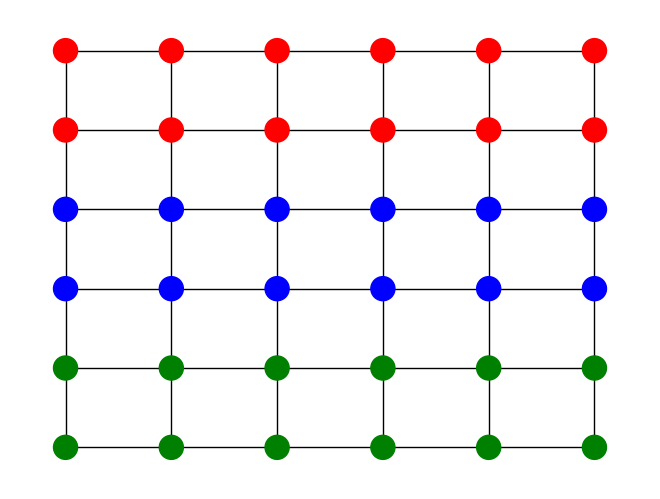

In [45]:
import gymnasium as gym
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math

class RedistrictingEnv(gym.Env):
    def __init__(self, grid_size=6, num_partitions=3):
        super(RedistrictingEnv, self).__init__()
        self.grid_size = grid_size
        self.num_partitions = num_partitions
        self.action_space = gym.spaces.Discrete(grid_size * grid_size)
        self.observation_space = gym.spaces.Box(low=0, high=num_partitions-1, shape=(grid_size, grid_size), dtype=np.int32)

        self.grid_graph = nx.grid_2d_graph(grid_size, grid_size)
        self.initialize_partitions()
        self.pos = {(x, y): (y, -x) for x, y in self.grid_graph.nodes()}
        self.reset()

    def initialize_partitions(self):
        partition_size = self.grid_size * self.grid_size // self.num_partitions
        for i, node in enumerate(self.grid_graph.nodes()):
            self.grid_graph.nodes[node]['partition'] = i // partition_size

    
    def step(self, action):
        # Convert action integer to grid coordinates
        x, y = action // self.grid_size, action % self.grid_size
        current_partition = self.grid_graph.nodes[(x, y)]['partition']
    
        # Prepare to switch to the next partition
        new_partition = (current_partition + 1) % self.num_partitions
    
        # Check if the action is valid (does not result in non-contiguous partitions)
        # Temporarily apply the action
        self.grid_graph.nodes[(x, y)]['partition'] = new_partition
        if not self.check_contiguity():
            # If not valid, revert the action and return a penalty
            self.grid_graph.nodes[(x, y)]['partition'] = current_partition
            reward = -1  # Penalty for non-contiguous partition
            done = True
        else:
            # If valid, keep the action and calculate reward
            compactness_scores = [self.calculate_polsby_popper(p) for p in range(self.num_partitions)]
            reward = (sum(compactness_scores) / len(compactness_scores))
            done = True

        # Prepare the new state to return
        state = np.array([[self.grid_graph.nodes[(i, j)]['partition'] for j in range(self.grid_size)] for i in range(self.grid_size)])
        return state, reward, done, {}


    def calculate_polsby_popper(self, partition):
        # Count the number of cells (area) and boundary edges (perimeter)
        area = sum(1 for _, node_data in self.grid_graph.nodes(data=True) if node_data['partition'] == partition)
        perimeter = 0
        for x, y in self.grid_graph.nodes():
            if self.grid_graph.nodes[(x, y)]['partition'] != partition:
                continue
            # Check all neighbors; if they are different or out of bounds, increase perimeter
            for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                nx, ny = x + dx, y + dy
                if (nx, ny) not in self.grid_graph or self.grid_graph.nodes[(nx, ny)]['partition'] != partition:
                    perimeter += 1

        if perimeter == 0:  # To avoid division by zero
            return 0

        polsby_popper = 4 * math.pi * area / perimeter**2
        return polsby_popper

    def check_contiguity(self):
        for p in range(self.num_partitions):
            partition_nodes = [n for n in self.grid_graph.nodes() if self.grid_graph.nodes[n]['partition'] == p]
            subgraph = self.grid_graph.subgraph(partition_nodes)
            if not nx.is_connected(subgraph):
                return False
        return True

    def reset(self):
        self.initialize_partitions()
        state = np.array([[self.grid_graph.nodes[(i, j)]['partition'] for j in range(self.grid_size)] for i in range(self.grid_size)])
        return state

    def render(self, mode='human'):
        partitions = [self.grid_graph.nodes[node]['partition'] for node in self.grid_graph.nodes()]
        cmap = ListedColormap(['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan'][:self.num_partitions])  # Update for more colors
        nx.draw(self.grid_graph, pos=self.pos, node_color=partitions, cmap=cmap, with_labels=False)
        plt.show()

# Create and test the environment
env = RedistrictingEnv()
state = env.reset()
env.render()
for _ in range(10):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    env.render()
    if done:
        # print("Non-contiguous partition detected. Ending episode with penalty.")
        break


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assuming each state is represented by a 4x4 grid
num_inputs = 10 * 10  
num_actions = env.action_space.n

class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 128)  # Adjust the input features to match the state size
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Episode: 0, Total reward: -1, Epsilon: 0.99934
Episode: 100, Total reward: -1, Epsilon: 0.9354926337000912
Episode: 200, Total reward: 0.5055280876966978, Epsilon: 0.8757244458413881
Episode: 300, Total reward: -1, Epsilon: 0.8197748196166595
Episode: 400, Total reward: -1, Epsilon: 0.7673997889048829
Episode: 500, Total reward: -1, Epsilon: 0.7183709744666713
Episode: 600, Total reward: -1, Epsilon: 0.6724745881056768
Episode: 700, Total reward: 0.5289416202472611, Epsilon: 0.6295105004536627
Episode: 800, Total reward: 0.5289416202472611, Epsilon: 0.5892913683143473
Episode: 900, Total reward: 0.5055280876966977, Epsilon: 0.5516418177608406
Episode: 1000, Total reward: -1, Epsilon: 0.5163976794246145
Episode: 1100, Total reward: 0.5289416202472611, Epsilon: 0.4834052726414909
Episode: 1200, Total reward: 0.5289416202472611, Epsilon: 0.45252073533321874
Episode: 1300, Total reward: 0.5289416202472611, Epsilon: 0.42360939670259845
Episode: 1400, Total reward: 0.4834918217667557, Epsilo

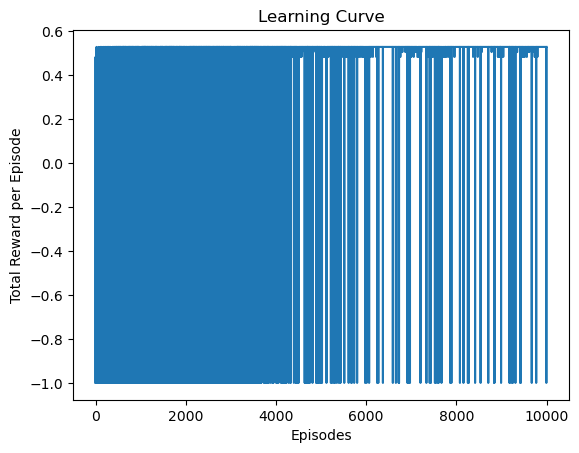

In [52]:
import torch.optim as optim
import numpy as np
import random
from collections import deque
import torch.nn.functional as F
import torch

# Hyperparameters
learning_rate = 0.005  # Consider adjusting
discount_factor = 0.99
num_episodes = 10000
batch_size = 64  # Consider increasing
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.99934   # Consider slowing the decay

# Environment setup
env = RedistrictingEnv(grid_size=10, num_partitions=3)
num_inputs = 10 * 10  
num_actions = env.action_space.n

# Define your DQN model here (not included in your snippet)

# Network and optimizer
policy_net = DQN(num_inputs, num_actions)
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Replay memory
replay_memory = deque(maxlen=50000)

# Function to select an action
def select_action(state, epsilon):
    state_tensor = torch.FloatTensor(state.flatten()).unsqueeze(0)  # Flatten and add batch dimension
    if random.random() > epsilon:
        with torch.no_grad():
            return policy_net(state_tensor).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(num_actions)]], dtype=torch.long)

# Function to optimize the model
def optimize_model():
    if len(replay_memory) < batch_size:
        return

    transitions = random.sample(replay_memory, batch_size)
    batch = list(zip(*transitions))

    # Extract states, actions, next_states, rewards, and dones
    states = torch.FloatTensor(np.array([s.flatten() for s in batch[0]]))
    actions = torch.cat(batch[1])
    rewards = torch.FloatTensor(np.array(batch[2]))
    next_states = torch.FloatTensor(np.array([s.flatten() for s in batch[3]]))
    dones = torch.FloatTensor(np.array(batch[4]))

    # Compute Q values
    state_action_values = policy_net(states).gather(1, actions)
    next_state_values = policy_net(next_states).max(1)[0].detach()
    expected_state_action_values = rewards + (discount_factor * next_state_values * (1 - dones))

    # Compute loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# List to store rewards for each episode - for plotting the learning curve
episode_rewards = []

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action.item())
        replay_memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        optimize_model()

    # Update epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Append episode reward to list
    episode_rewards.append(total_reward)
    if episode % 100 == 0:
        print(f"Episode: {episode}, Total reward: {total_reward}, Epsilon: {epsilon}")
        # env.render()

# After training, you can plot the learning curve here
import matplotlib.pyplot as plt

plt.plot(episode_rewards)
plt.title('Learning Curve')
plt.xlabel('Episodes')
plt.ylabel('Total Reward per Episode')
plt.show()


In [50]:
# Calculate a rolling mean for the rewards
window_size = 50  # Adjust as needed
rolling_mean_rewards = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')

# Plot the smoothed learning curve
plt.plot(rolling_mean_rewards)
plt.title('Smoothed Learning Curve')
plt.xlabel('Episodes')
plt.ylabel('Rolling Mean of Total Reward per Episode')
# plt.show()
plt.savefig(f"learning_curve_6.png")
plt.close()

tensor([[21]])

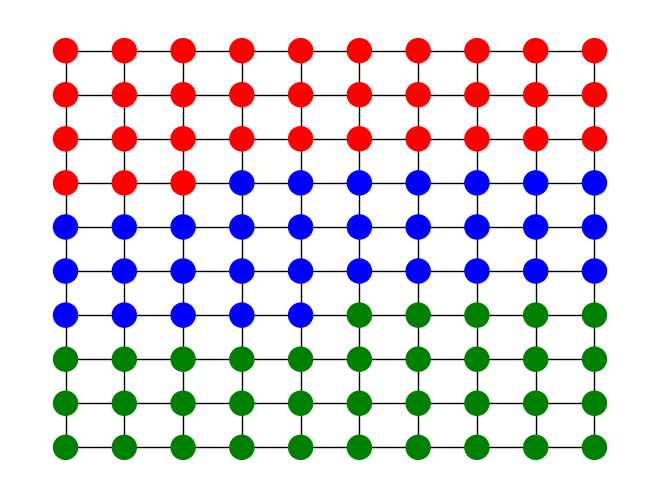

Episode: 0, Total reward: 0.5289416202472611


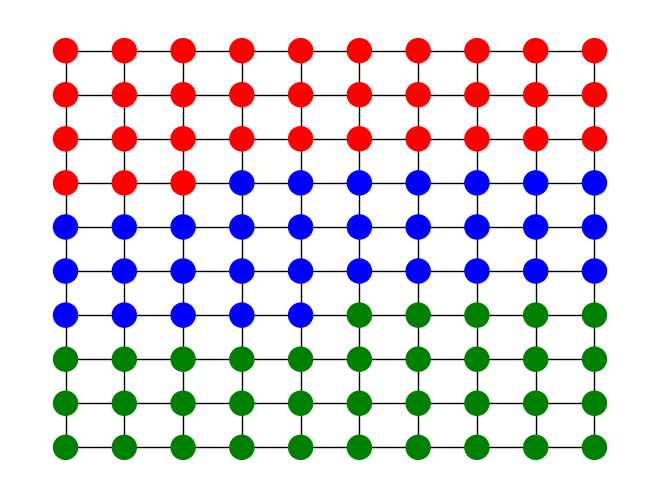

Episode: 1, Total reward: 0.5289416202472611


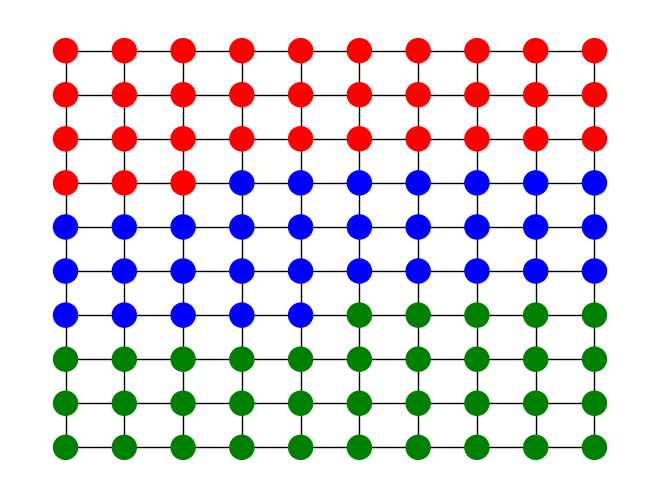

Episode: 2, Total reward: 0.5289416202472611


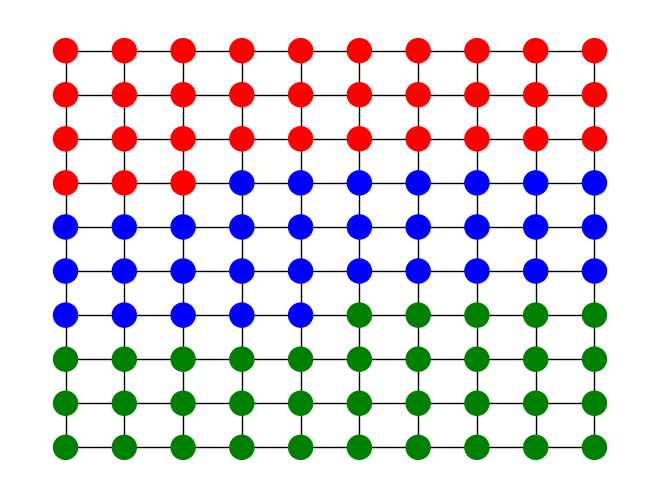

Episode: 3, Total reward: 0.5289416202472611


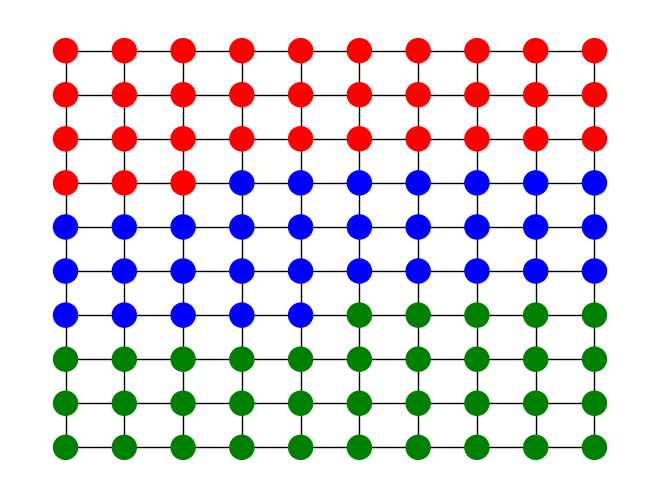

Episode: 4, Total reward: 0.5289416202472611


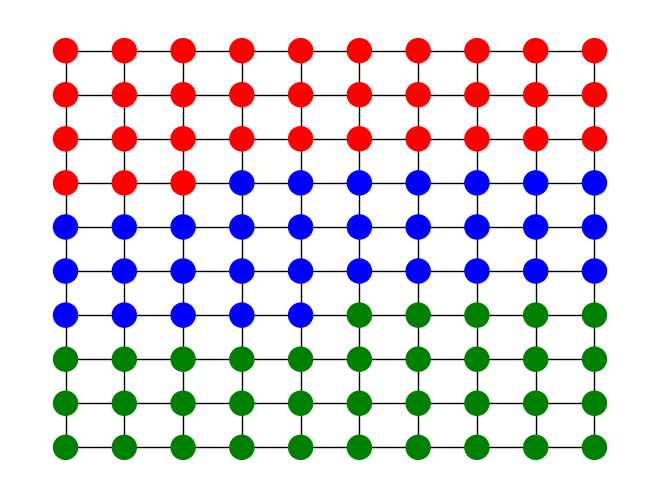

Episode: 5, Total reward: 0.5289416202472611


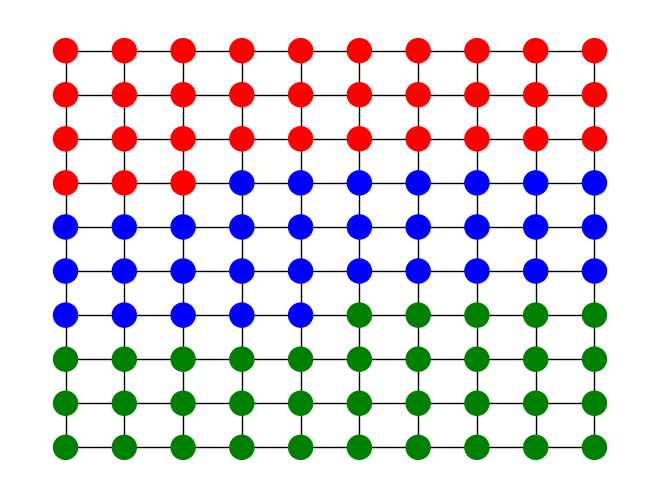

Episode: 6, Total reward: 0.5289416202472611


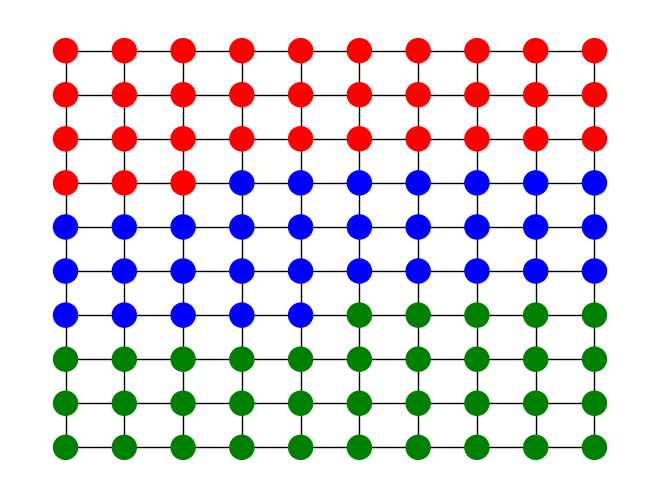

Episode: 7, Total reward: 0.5289416202472611


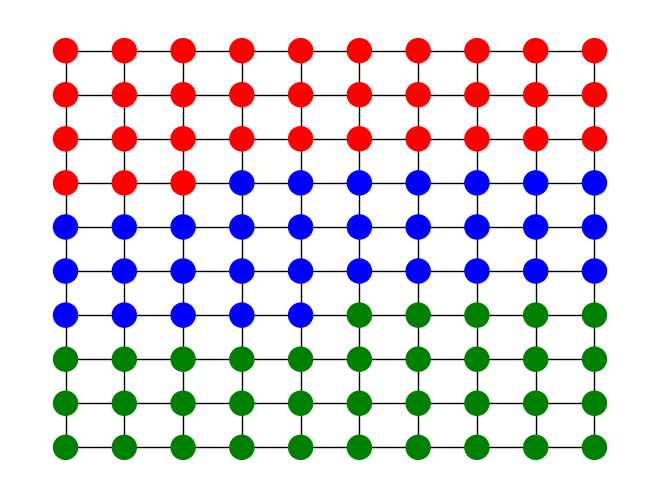

Episode: 8, Total reward: 0.5289416202472611


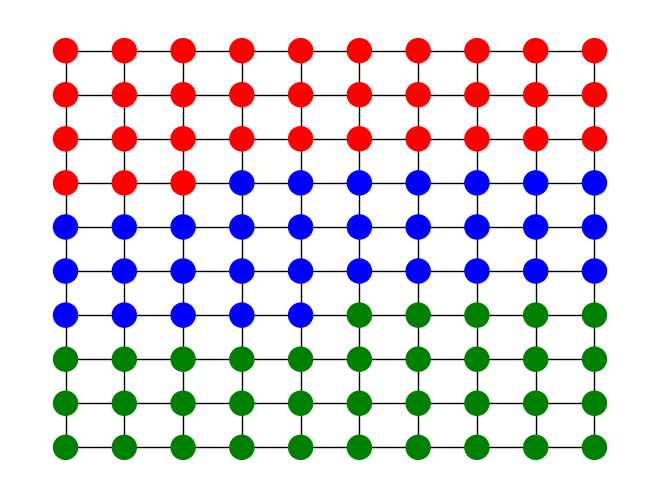

Episode: 9, Total reward: 0.5289416202472611


In [53]:
# Number of episodes to visualize after training
num_evaluation_episodes = 10

# Disable exploration
epsilon = 0.0

# Run the model in evaluation mode
for episode in range(num_evaluation_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        # Select action based on the trained policy (no exploration)
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action.item())

        # Optionally, render the state at each step or only at episode end
        env.render()

        state = next_state
        total_reward += reward

    print(f"Episode: {episode}, Total reward: {total_reward}")

    # Pause or wait for user input to continue to the next episode
    # input("Press Enter to continue to the next episode...")
